# Agglomerative Clustering

In [2]:

!pip install -U scikit-learn

First thing first, let's use the generator tools from previous works

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.cluster import AgglomerativeClustering as agg

def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster


def plot_loss(loss):
    plt.figure()
    plt.plot(range(len(loss)),loss)
    plt.title("loss vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|loss|")
    plt.show()

def get_rand_centroids(K,d):
    centroids = np.random.rand(K, d)
    return centroids

In [42]:

def generate_clusters(k, d = 2,N = 600, distance = 2):
    """
    generate k clusters of d-dimensional data

    :param k:           number of clusters
    :param d:           dimension of the data
    :param distance:    expected distance of the mean from the origin
    :return:            clusters - a list of clusters, where each cluster is a numpy array of datapoints
                        data - a numpy array of all the datapoints
                        phi - a numpy array of the priors of each cluster
                        sigma - a numpy array of the covariance matrices of each cluster
    """
    phi = np.random.rand(k)
    phi = phi/np.sum(phi)
    print(phi)

    # random distributions
    distributions = [get_random_gaussian_dist(d,distance) for i in range(k)]
    print(distributions[0])
    # generate clusters
    clusters = [generate_gaussian_cluster(distribution,int(phi[i]*N),d) for i, distribution in enumerate(distributions)]

    sigma = [distribution[1] for distribution in distributions]
    data = np.concatenate(clusters,axis=0)

    return clusters, data, phi, sigma



def plot_clusters(clusters, d = 2,title = None,ax = None):

    """
    Function to plot the clusters
    input: clusters - a list of clusters, where each cluster is a numpy array of datapoints
           d - the dimension of the data
    output: a plot of the clusters, where each cluster is a different color, and the datapoints are transparent to show overlapping clusters

    """
    if not ax:
        plt.figure()
    if d == 2:
        for c in clusters:
            plt.scatter(c[:,0], c[:, 1], alpha=0.5)
    else:
        #ax = plt.axes(projection='3d')

        for c in clusters:
            ax.scatter3D(c[:,0], c[:, 1], c[:, 2], alpha=0.5)
    if title:
        plt.title(title)


def plot_centroids(centroids, d = 2,title = None):
    """
    Function to plot the centroids
    input: centroids - a numpy array of centroids
           d - the dimension of the data
    output: a plot of the centroids, where each centroid is a different color

    """
    if d == 2:
        for c in centroids:
            plt.scatter(c[0],c[1],marker='x',s=100)
    else:
        for c in centroids:
            ax.scatter3D(c[0], c[1], c[2], marker='x', s=100)


In [6]:
def get_gaussian_line_shape_distribution(p1,p2):
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    u = v/v_norm

    sigma = v_norm * np.outer(u,u)

    epsilon = 0.005 * np.identity(sigma.shape[0])
    sigma +=epsilon

    mu = p1 + (p2 - p1)/2

    return mu, sigma



## generate the data

In [7]:

K = 7
d = 2
N = 1000
distance = 6
max_iters = 50
fuzziness = 2

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)

[0.28596672 0.04713911 0.14419889 0.07829024 0.05353753 0.30781861
 0.0830489 ]
(array([1.62651454, 1.90278292]), array([[ 0.01144224, -0.01519703],
       [-0.01519703,  0.05865142]]))


## plot the data

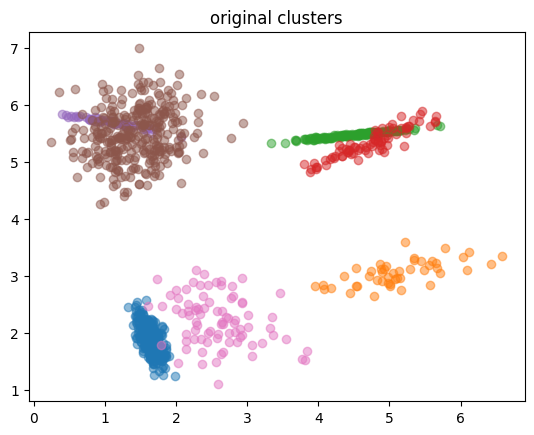

In [8]:
plot_clusters(clusters,d,title="original clusters")

# Agglomerative clustering

Aggumulative clustering is a bottom-up approach to clustering. The algorithm starts with each datapoint as a cluster, and then merges the two closest clusters iteratively until the desired number of clusters is reached, according to some distance metric.

the algorithm runs acording to the following pseudo-code:
#####   Input:

- data: A set of n data points, where data = {x1, x2, ..., xn}
- distance_function: A function that calculates the distance between two clusters, for example, d(ci, cj) denotes the distance between clusters ci and cj.
#####   Output:

- clusters: A set of clusters obtained from the agglomerative clustering algorithm.

##### Initialization:

Initialize $n$ clusters, each containing a single data point: $ci = {xi}$ for $i \in \{1... n\}$.
Compute the distance matrix D with D[i, j] = distance_function(ci, cj) for all pairs of clusters.

##### Agglomerative Cluster($K$, data $x$, distance_function $f$):
While the number of clusters is greater than 1, do the following:

1. Find the two closest clusters ca and cb based on the distance matrix $D$:
$$c_a, c_b = argmin_{c_i, c_j} D[i, j]$$

2. Merge the closest clusters $c_a$ and $c_b$ into a new cluster c_new:
$$c_{new} = c_a ∪ c_b$$

3. Update the distance matrix $D$ to reflect the new distances between the merged cluster $c_new$ and the remaining clusters:
$D[new, k]$ = $f(c_{new}, c_k)$ for all clusters ck in the remaining clusters

Remove the rows and columns corresponding to $c_a$ and $c_b$ from $D$.

##### Output:
Return the final set of clusters after the algorithm terminates.



In [9]:
def agglomerative_cluster(data, K, linkage='ward'):
    """
    :param data:
    :param n_clusters:
    :param linkage:
    :return:
    """
    clustering = agg()
    clustering.n_clusters = K
    clustering.linkage = linkage
    clustering.fit(data)

    labels = clustering.labels_

    clusters = [data[labels == i] for i in range(K)]
    plot_clusters(clusters,d,title="Agglomerative clustering")
    return clusters

def agglomerative_cluster_plot_steps(data, K, linkage='ward',plot = False):
    """
    :param data:
    :param n_clusters:
    :param linkage:
    :return:
    """
    clustering = agg()
    n_steps = 5
    steps = [K + 5*(n_steps-1-k) for k in range(n_steps)]
    for k in range(len(steps)):
        clustering.n_clusters = steps[k]
        clustering.linkage = linkage
        clustering.fit(data)
        labels = clustering.labels_

        clusters = [data[labels == i] for i in range(steps[k])]
        if plot:
            plot_clusters(clusters,d,title=f" {steps[k]} components")
        plt.pause(0.5)
        plt.clf()

    return clusters

def agglomerative_cluster_plot_steps(data, K, linkage='ward'):
    """
    :param data:
    :param n_clusters:
    :param linkage:
    :return:
    """
    clustering = agg()
    n_steps = 5
    steps = [K + 5*(n_steps-1-k) for k in range(n_steps)]
    for k in range(len(steps)):
        clustering.n_clusters = steps[k]
        clustering.linkage = linkage
        clustering.fit(data)
        labels = clustering.labels_

        clusters = [data[labels == i] for i in range(steps[k])]
        plot_clusters(clusters,d,title=f" {steps[k]} components")
        plt.pause(0.5)
        plt.clf()

    return clusters

## try the algorithm on a data

here we will try the algorithm on the data we generated above, and see how it performs. it is a dataset consisting of 7 clusters, 1000 2D data points, and the clusters are separated by a mean distance of 6, which creates a noticeable distinction. we will try to cluster the data into 7 clusters, and see how the algorithm performs.


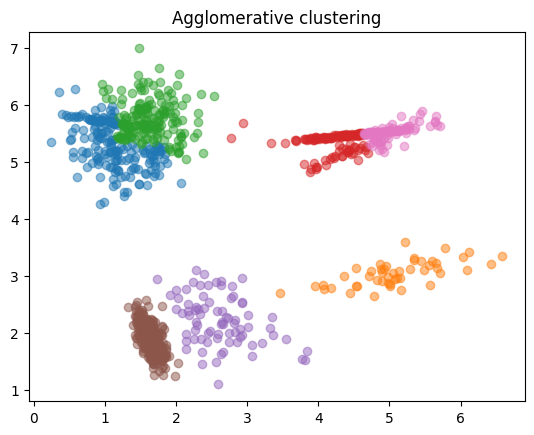

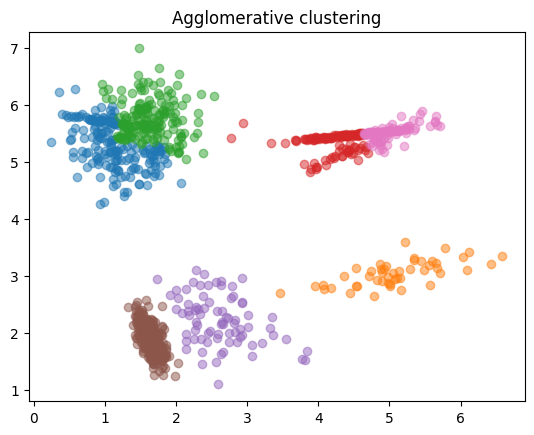

In [10]:

clusters = agglomerative_cluster(data,K)
plot_clusters(clusters,d,title="Agglomerative clustering")


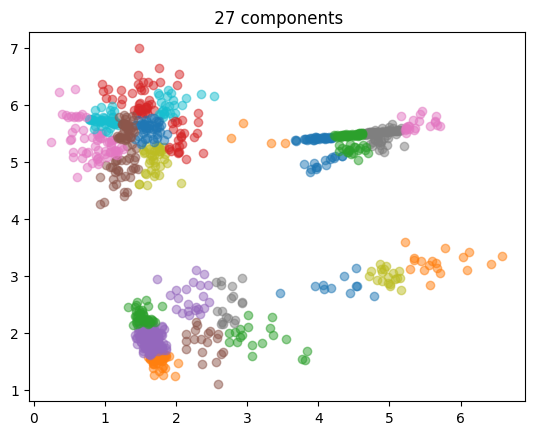

<Figure size 640x480 with 0 Axes>

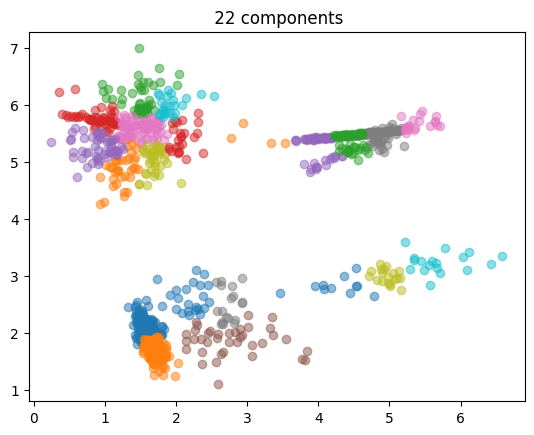

<Figure size 640x480 with 0 Axes>

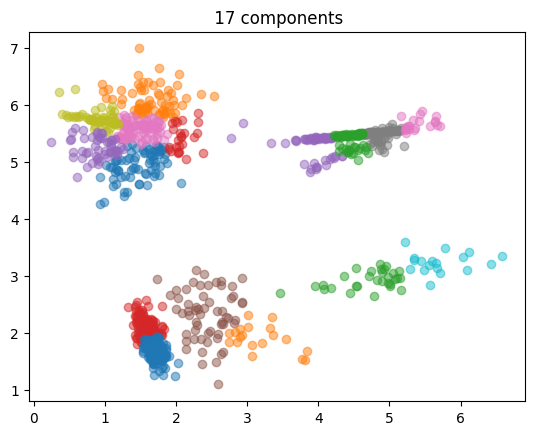

<Figure size 640x480 with 0 Axes>

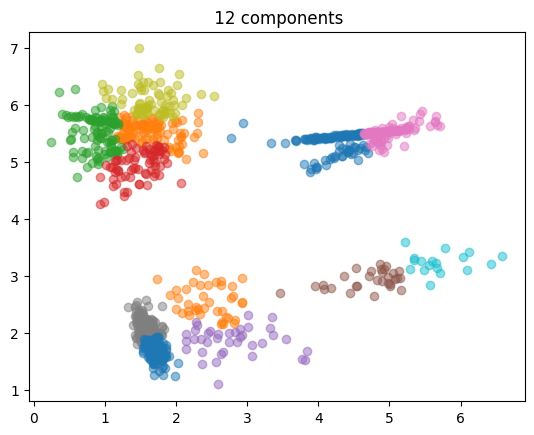

<Figure size 640x480 with 0 Axes>

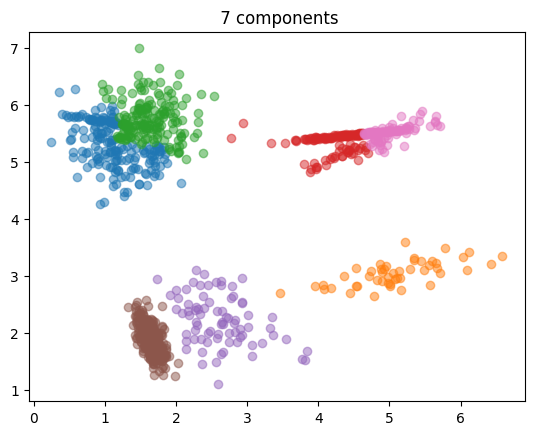

<Figure size 640x480 with 0 Axes>

In [11]:

clusters = agglomerative_cluster_plot_steps(data,K)

## results

# different distance metrics
in the agglomerative clustering algorithm, we need to define a distance metric between two clusters for finding the two clusters to unify in step 1. note that the distance metric is not the same as the distance metric between two points $d_{i,j}$, rather it is a distance metric between two cluster of datapoints $d_
{metric}(C_i,C_j)$, as we would like to find the two clusters to unify in this step.

 There are several options for this metric, and we will discuss three of them, and try each on the same dataset

## $d_{min}$

this distance metric is also known as the single linkage distance. It is defined as the distance between the two closest points in the two clusters. Formally, it is defined as: $$d_{min}(c_i, c_j) = min_{x_i \in c_i, x_j \in c_j} ||x_i, x_j||$$



### generate the data

In [12]:

K = 7
d = 2
N = 1000
distance = 8

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)

[0.23560624 0.13946135 0.0750468  0.2986594  0.08346938 0.15542163
 0.0123352 ]
(array([6.27107111, 6.66008351]), array([[0.19954644, 0.00979579],
       [0.00979579, 0.10605257]]))


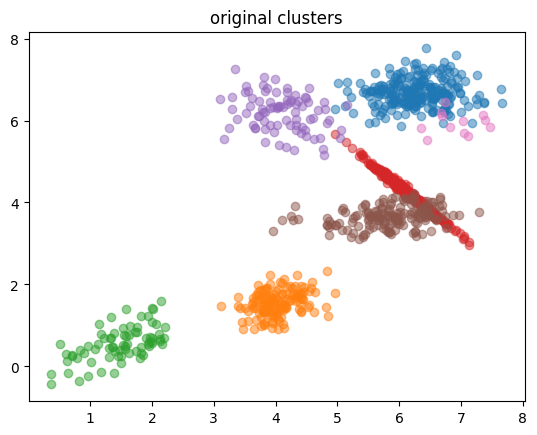

In [13]:
plot_clusters(clusters,d,title="original clusters")

### try the distance measure

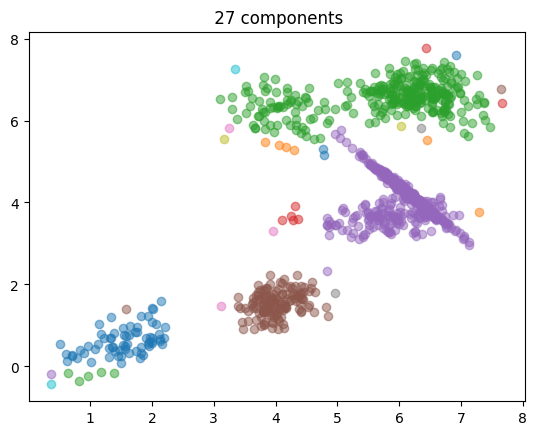

<Figure size 640x480 with 0 Axes>

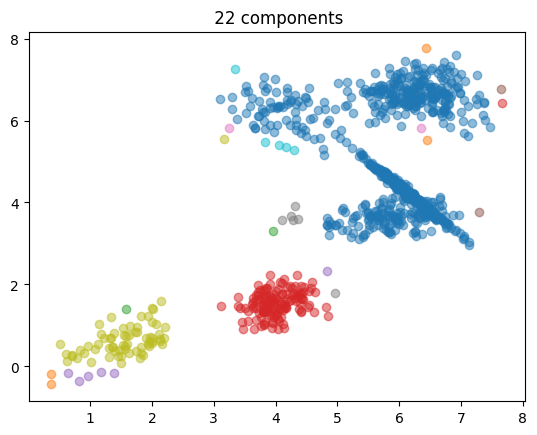

<Figure size 640x480 with 0 Axes>

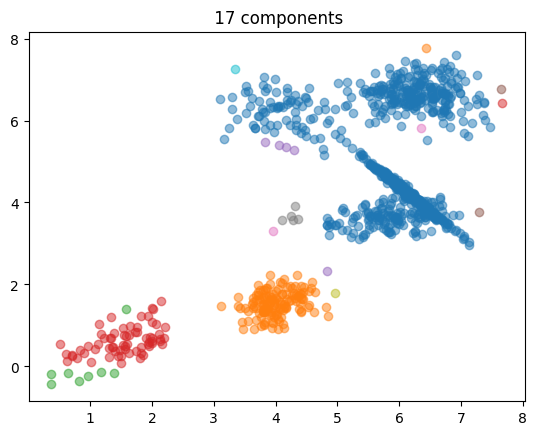

<Figure size 640x480 with 0 Axes>

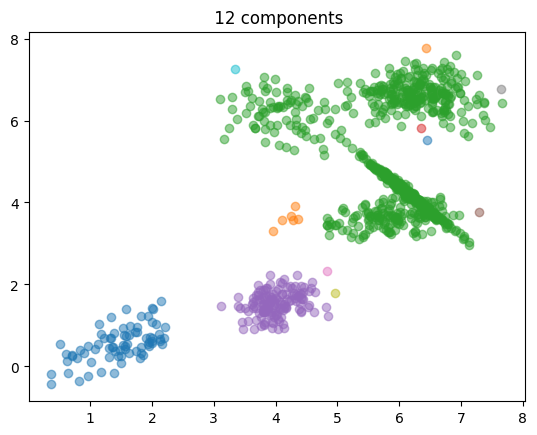

<Figure size 640x480 with 0 Axes>

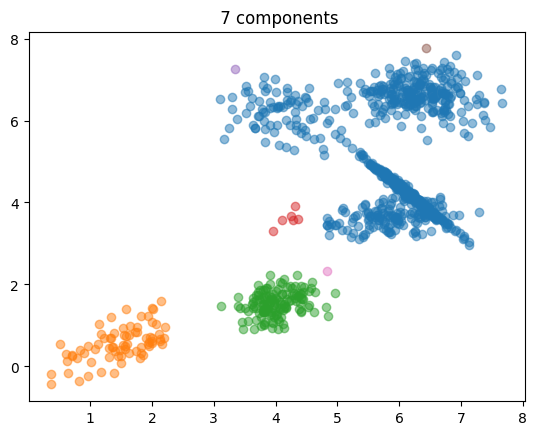

<Figure size 640x480 with 0 Axes>

In [14]:

clusters = agglomerative_cluster_plot_steps(data,K, linkage='single')


### results

## $d_{max}$

this linkage uses the maximum distances between all observations of the two sets. it seems counterintuitive to use the max distance, but we calculate it in order to merge clusters whose two farthest data points have the smallest distance.


### run the algorithm

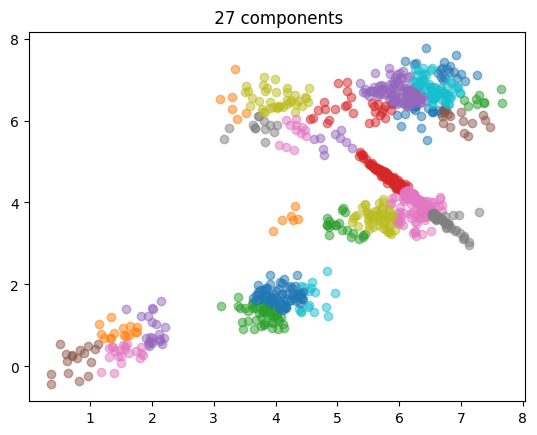

<Figure size 640x480 with 0 Axes>

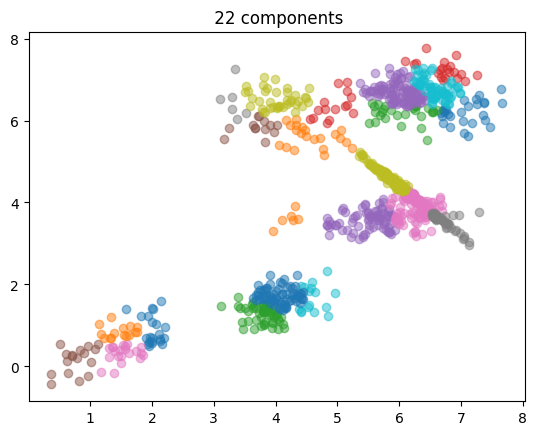

<Figure size 640x480 with 0 Axes>

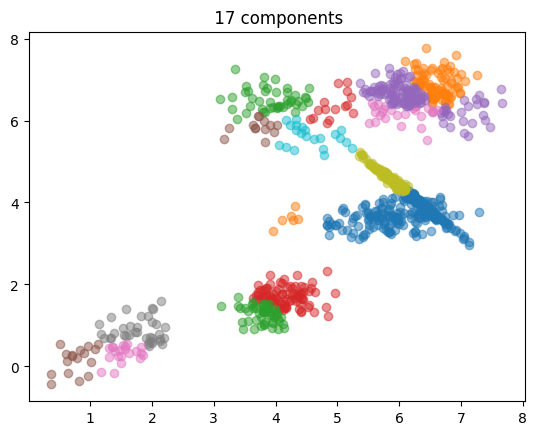

<Figure size 640x480 with 0 Axes>

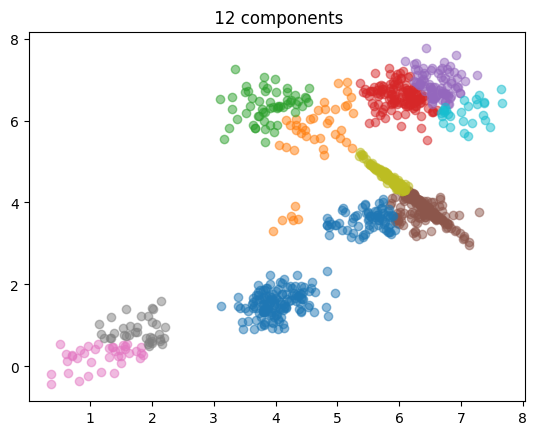

<Figure size 640x480 with 0 Axes>

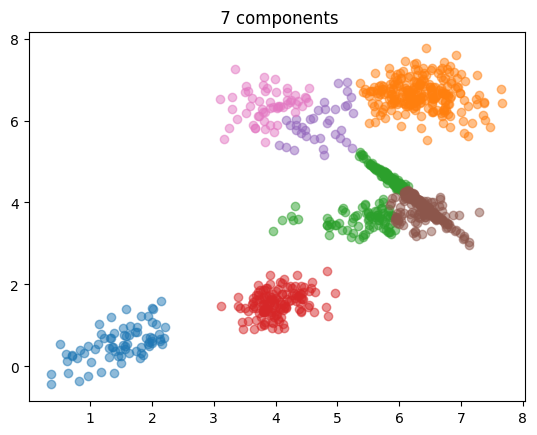

<Figure size 640x480 with 0 Axes>

In [15]:
clusters = agglomerative_cluster_plot_steps(data,K,'complete')



### results

## $d_{avg}$
 in this metric, we merge clusters based on the average similarity of all pairs of data points from the two clusters.



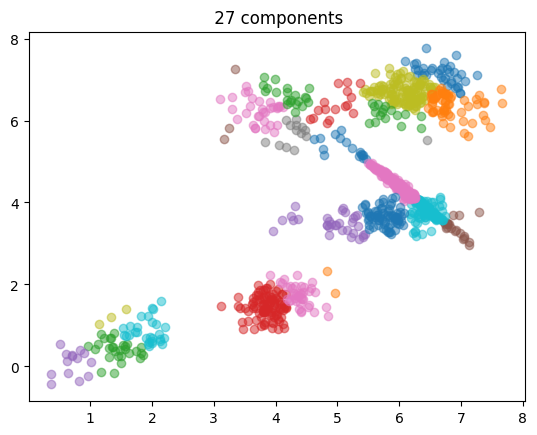

<Figure size 640x480 with 0 Axes>

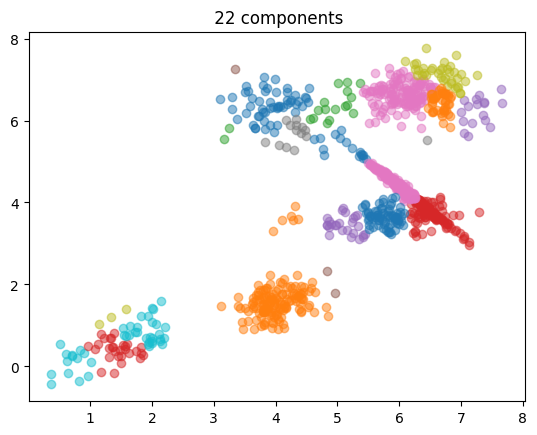

<Figure size 640x480 with 0 Axes>

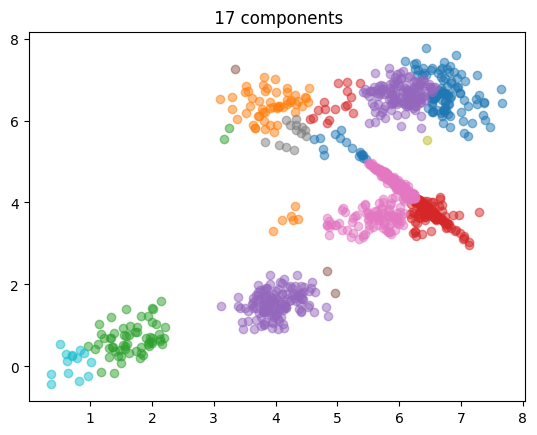

<Figure size 640x480 with 0 Axes>

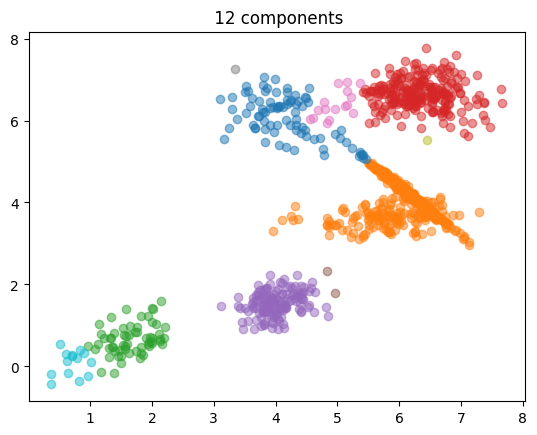

<Figure size 640x480 with 0 Axes>

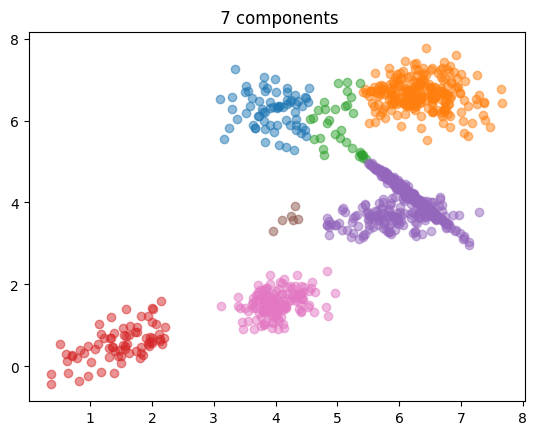

<Figure size 640x480 with 0 Axes>

In [16]:
clusters = agglomerative_cluster_plot_steps(data,K,'average')

## $d_{mean}$
in this metric, we try to minimize the distance between means of different clusters

### run the algorithm with mean distance metric

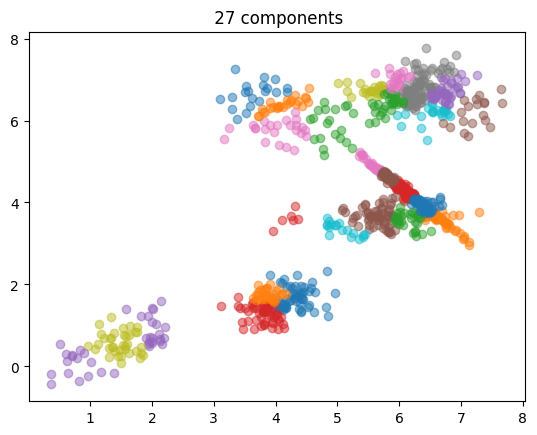

<Figure size 640x480 with 0 Axes>

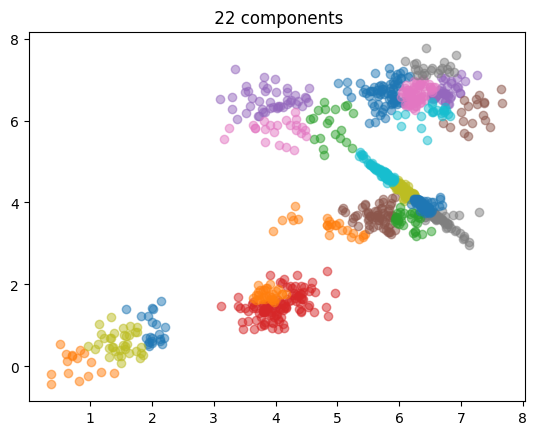

<Figure size 640x480 with 0 Axes>

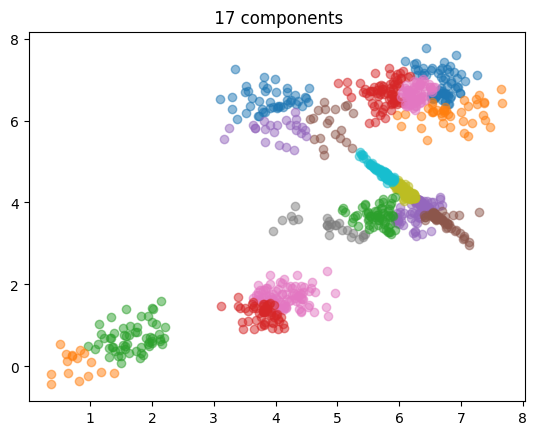

<Figure size 640x480 with 0 Axes>

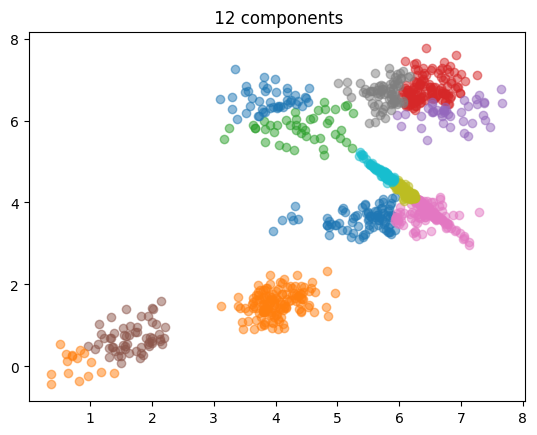

<Figure size 640x480 with 0 Axes>

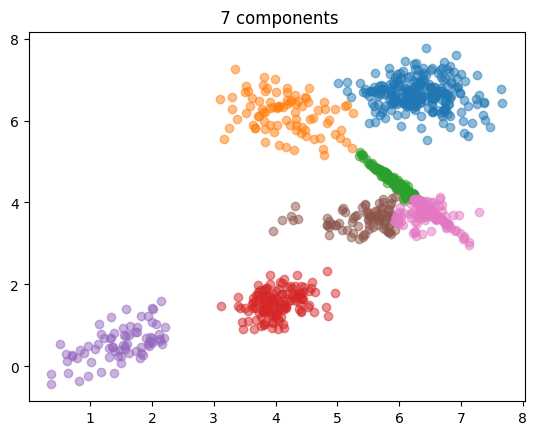

<Figure size 640x480 with 0 Axes>

In [17]:
clusters = agglomerative_cluster_plot_steps(data,K)

### results

# 2nd Dataset: 3D data

## Generate the data

In [18]:
K = 3
d = 3
N = 1000
distance = 4

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)
print(len(clusters))

[0.41017492 0.42482041 0.16500467]
(array([0.76416036, 1.33982559, 3.96253147]), array([[ 0.23606561, -0.09258331,  0.16293126],
       [-0.09258331,  0.3663553 ,  0.03442604],
       [ 0.16293126,  0.03442604,  0.37002048]]))
3


## plot the data

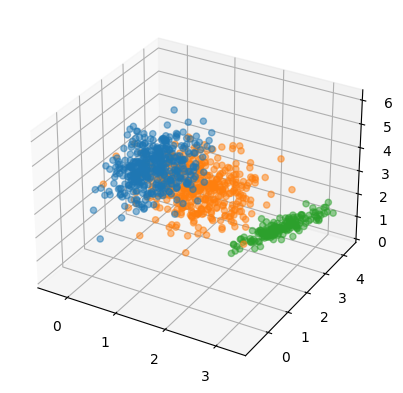

In [19]:
plot_clusters(clusters,d)

## run the algorithm

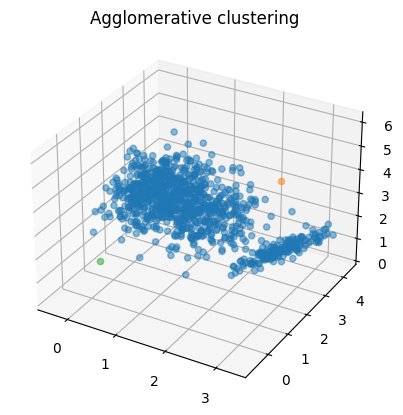

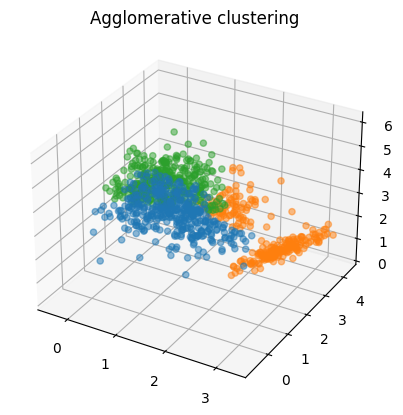

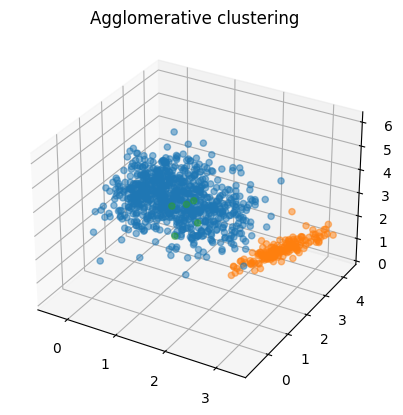

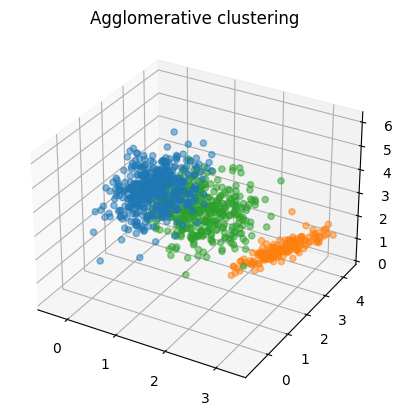

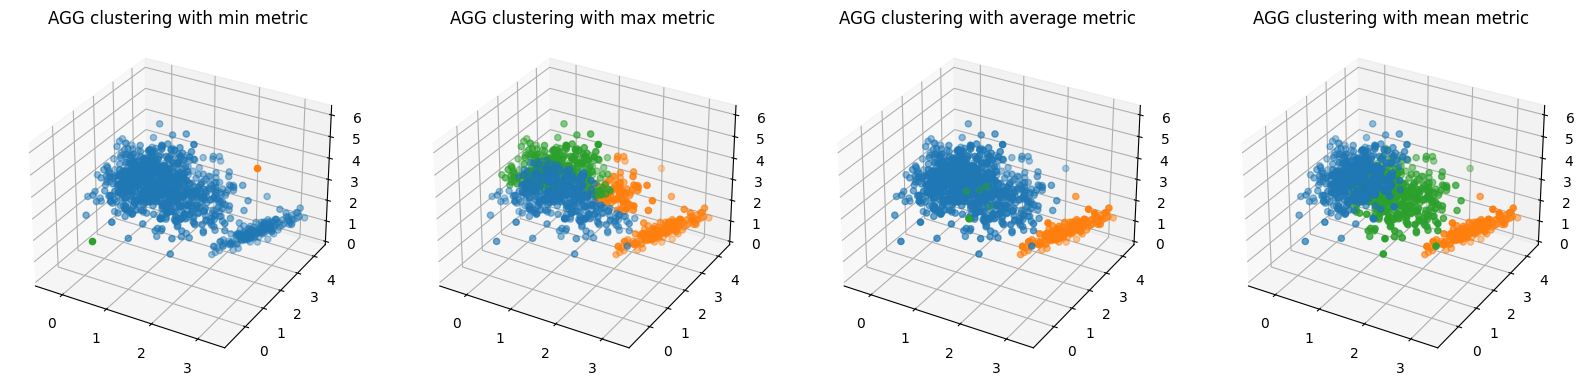

In [53]:
cluster_sets =[]
cluster_sets.append( agglomerative_cluster(data,K,linkage='single') )
cluster_sets.append( agglomerative_cluster(data,K,linkage='complete') )
cluster_sets.append( agglomerative_cluster(data,K,linkage='average') )
cluster_sets.append( agglomerative_cluster(data,K,linkage='ward') )

linkage = ['min','max','average','mean']
fig = plt.figure(figsize=(20,10))
for i in range(4):
    ax = fig.add_subplot(1,4,i+1, projection='3d')
    for j in range(K):
        ax.scatter(cluster_sets[i][j][:,0],cluster_sets[i][j][:,1],cluster_sets[i][j][:,2])
    ax.set_title(f"AGG clustering with {linkage[i]} metric")

